<a href="https://colab.research.google.com/github/walunjab09/Time-series-forecasting/blob/main/LSTM_Stock_market_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import numpy as np

In [3]:
df=pd.read_excel('aapl.xlsx')
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2015-05-27 00:00:00+00:00,132.045,132.260,130.05,130.34,45833246,121.682558,121.880685,119.844118,120.111360,45833246,0.0,1
1,AAPL,2015-05-28 00:00:00+00:00,131.780,131.950,131.10,131.86,30733309,121.438354,121.595013,120.811718,121.512076,30733309,0.0,1
2,AAPL,2015-05-29 00:00:00+00:00,130.280,131.450,129.90,131.23,50884452,120.056069,121.134251,119.705890,120.931516,50884452,0.0,1
3,AAPL,2015-06-01 00:00:00+00:00,130.535,131.390,130.05,131.20,32112797,120.291057,121.078960,119.844118,120.903870,32112797,0.0,1
4,AAPL,2015-06-02 00:00:00+00:00,129.960,130.655,129.32,129.86,33667627,119.761181,120.401640,119.171406,119.669029,33667627,0.0,1


In [4]:
# Resetting index and selecting only one column for prediction
df1=df.reset_index()['close']

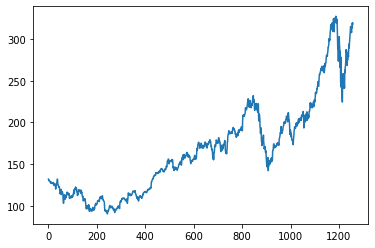

In [5]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [7]:
# LSTM is sensitive to scale of the data. Applying feature scaling to bring it in a range

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [8]:
# Splitting dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [9]:
# Function for converting values to supervised dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [10]:
# Converting raw data to supervised matrix (current time value is output and last 100 values are inputs)

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [11]:
# Reshaping input data to 3d as required by LSTM
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [12]:
# Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [20]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(time_step,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [21]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=50,batch_size=64,verbose=1)

Epoch 1/50
12/12 [==============================] - 9s 311ms/step - loss: 0.0135 - val_loss: 0.0729
Epoch 2/50
12/12 [==============================] - 2s 179ms/step - loss: 0.0038 - val_loss: 0.0043
Epoch 3/50
12/12 [==============================] - 2s 175ms/step - loss: 0.0012 - val_loss: 0.0063
Epoch 4/50
12/12 [==============================] - 2s 177ms/step - loss: 8.9945e-04 - val_loss: 0.0038
Epoch 5/50
12/12 [==============================] - 2s 175ms/step - loss: 6.7133e-04 - val_loss: 0.0050
Epoch 6/50
12/12 [==============================] - 2s 176ms/step - loss: 6.2963e-04 - val_loss: 0.0044
Epoch 7/50
12/12 [==============================] - 2s 177ms/step - loss: 6.5583e-04 - val_loss: 0.0042
Epoch 8/50
12/12 [==============================] - 2s 176ms/step - loss: 6.0330e-04 - val_loss: 0.0042
Epoch 9/50
12/12 [==============================] - 2s 175ms/step - loss: 6.0313e-04 - val_loss: 0.0038
Epoch 10/50
12/12 [==============================] - 2s 176ms/step - loss: 5

In [22]:
# Predictions
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [23]:
test_predict.shape

(340, 1)

In [24]:
# Transforming predictions to the original scale
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [25]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

142.3372146684245

In [26]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

234.0695198522124

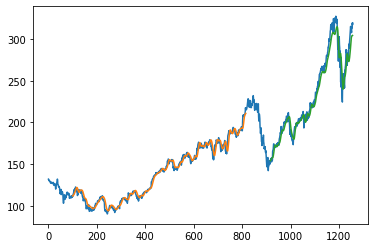

In [28]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [29]:
# Predicting future 30 days data

x_input=test_data[341:].reshape(1,-1)
x_input.shape

(1, 100)

In [30]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [31]:
lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.9071172]
101
1 day input [0.8866419  0.87431394 0.88431985 0.87836697 0.8986321  0.92582116
 0.92877649 0.95676771 0.93869797 0.93304061 0.94950604 0.96424048
 0.95512117 0.95989192 0.96635143 0.96246728 0.92295027 0.9598497
 0.98792536 0.98594106 0.92531453 0.92172591 0.96474711 0.97572406
 0.99159841 0.96972895 0.97614625 0.96795575 1.         0.99016297
 0.99050072 0.96538039 0.98488559 0.97086887 0.94026007 0.87748037
 0.83483915 0.85413324 0.77336823 0.77269273 0.88014017 0.84007431
 0.89673225 0.85527316 0.83884995 0.74233725 0.82327113 0.78143207
 0.6665963  0.7921557  0.64118044 0.68614371 0.66001013 0.65203074
 0.58642236 0.56586169 0.66089673 0.65515494 0.70970193 0.66452757
 0.69437642 0.69218104 0.63569197 0.65266402 0.63780292 0.7267162
 0.71388162 0.74191506 0.75002111 0.77222832 0.83049059 0.8194292
 0.8289707  0.8125475  0.78776492 0.75162543 0.78426074 0.77974331
 0.81326522 0.8141096  0.79473106 0.83336148 0.85898843 0.83901883
 0.85628641 0.87486279 0.88782403 0.9

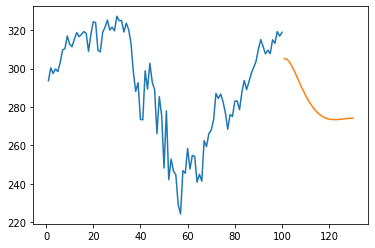

In [32]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

plt.plot(day_new,scaler.inverse_transform(df1[-100:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

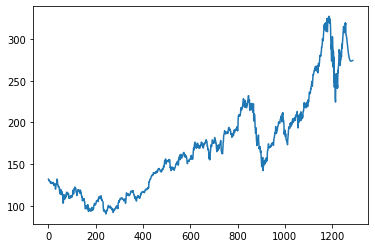

In [33]:
df3=df1.tolist()
df3.extend(lst_output)
df3=scaler.inverse_transform(df3).tolist()
plt.plot(df3)